PPCA lavora con più variabili osservabili anzichè una sola

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import aesara.tensor as at
import arviz as az
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from scipy import stats
import scipy
import pandas as pd

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
scaler = StandardScaler()

In [3]:
#data = np.load('prova.npy', allow_pickle=True).item()

# extract data social anxiety

In [4]:
#csv_ = '/Users/marcoghezzi/PycharmProjects/pythonProject/osfstorage-archive/behavior/LookAtMe_002.csv'
csv_ = '/home/paolo/matteo/matteo/unimi/tesi_master/code/osfstorage-archive/behavior/LookAtMe_002.csv'
global_data = pd.read_csv(csv_, sep='\t')
y = np.array(list([int(d>2) for d in global_data['rating']]))
e_labels = y[:,np.newaxis]  # rating > 2

In [7]:
print(len(e_labels))

160


In [8]:
num_trials_to_remove = 48

In [9]:
e_labels= e_labels[num_trials_to_remove:]

In [10]:
print(len(e_labels))

112


In [11]:
N_e = e_labels.shape[0]
D_e = e_labels.shape[1]
print(N_e,D_e)

112 1


## test with new data

In [12]:
import deepemogp.feature_extractor as feature_extractor
import deepemogp.signal.physio as physio
import deepemogp.signal.face as face
import deepemogp.signal.annotation as annotation
import deepemogp.datasets as datasets
import deepemogp.signal.behavior as behavior

# from: https://github.com/SheffieldML/GPy
#import GPy
# from: https://github.com/SheffieldML/PyDeepGP
#import deepgp

import pandas as pd
import numpy as np

show = False
# definition of the feature extractors to be used later
f2 = feature_extractor.FE('wavelet', window=(2, 1))
f3 = feature_extractor.FE('mean', window=(1,0))

# definition of the physiological signals to be extracted
eda_ = physio.EDA(f2)
hr_ = physio.HR(f2)
pupil_ = behavior.PUPIL(f3)

# definition of the emotional annotation to be extracted
#va = annotation.VA('valence', f3)
#ar = annotation.VA('arousal', f3)
# extraction of the desired data from the dataset
d = datasets.FEAR(signals={hr_,pupil_,eda_}, subjects={'45'})

for s in d.signals:
    # preprocess ...
    if s.name =='EDA':
        s.preprocess(show=show,new_fps=500)
        s.feature_ext.extract_feat(s,show=show)
    else:
        s.feature_ext.extract_feat_without_preprocess(s, show=show)

    #add feature extraction for eda before preprocessing

    # ... and extract features from each signal type


for sig in d.signals:
    if sig.name=='EDA':
        eda_data = sig.features
    if sig.name=='HR':
        hr_data = sig.features
    if sig.name=='PUPIL':
        pupil_data = sig.features

>> Loading HR for subject 45 and all sessions from dataset FEAR
>> Loading EDA for subject 45 and all sessions from dataset FEAR
>> Loading PUPIL for subject 45 and all sessions from dataset FEAR
>> Extracting wavelet features from HR signal, adopting (2, 1) window ...
>> Processing EDA ...
>> Extracting wavelet features from EDA signal, adopting (2, 1) window ...
>> Extracting mean features from PUPIL signal, adopting (1, 0) window ...


In [13]:
'''for sig in d.signals:
    print (sig.name)
    print (sig.features)'''

'for sig in d.signals:\n    print (sig.name)\n    print (sig.features)'

In [14]:
list(d.signals)[0].name
d.signals

{<deepemogp.signal.physio.eda.EDA at 0x7f3489163850>,
 <deepemogp.signal.behavior.pupil.PUPIL at 0x7f347fdcb670>}

In [15]:
np.array(hr_data)

array([[-0.38142145, -0.40542215, -0.34758225, ..., -0.36067785,
        -2.35814025,  9.88335292],
       [ 0.33450701,  0.42477836,  0.47827066, ..., -0.49997384,
        -1.43463106,  7.7776058 ],
       [ 5.10511103,  5.10874739,  5.92213672, ..., -0.97753104,
         0.46582838, -1.31801106],
       ...,
       [-0.53066769, -0.50790145, -0.48890168, ..., -0.70502151,
         0.29068673, -1.59511346],
       [ 0.07194659,  0.17061241,  0.2278366 , ..., -0.69959388,
         0.57142862,  0.07306171],
       [-0.90295272, -0.87448703, -0.94036985, ..., -0.76705105,
         0.45519753,  0.69424375]])

In [16]:
TRIAL = 160

In [17]:
hr =np.array(hr_data)
np.shape(hr)

(800, 12)

In [18]:
hr = hr.reshape((TRIAL, int(hr.shape[0]/TRIAL*hr.shape[1])))
hr= hr[num_trials_to_remove:]
np.shape(hr)

(112, 60)

In [17]:
pupil = np.array(pupil_data)
pupil = pupil.reshape((TRIAL, int(pupil.shape[0]/TRIAL*pupil.shape[1])))
pupil = pupil[num_trials_to_remove:]
pupil

array([[2.40250466, 2.37169159, 2.36570188, 2.35041599, 2.47305837],
       [2.41146966, 2.41482795, 2.38192518, 2.53472461, 2.48704415],
       [2.32583225, 2.39622478, 2.33995162, 2.40282316, 2.39286294],
       [2.28481883, 2.34711499, 2.32480409, 2.2599998 , 2.27802137],
       [2.31378721, 2.43029428, 2.39475066, 2.39910228, 2.80852755],
       [2.27842355, 2.24664539, 2.28061958, 2.20779683, 2.19704274],
       [2.20882489, 2.23173331, 2.23084701, 2.22071175, 2.21912347],
       [2.33323625, 2.35953026, 2.21614763, 2.46110468, 2.89351463],
       [2.35553171, 2.13488027, 2.13519995, 2.14101585, 2.45607232],
       [2.31797205, 2.20270688, 2.24111266, 2.27653133, 2.3885289 ],
       [2.35800178, 2.43101031, 2.45240605, 2.58826663, 2.58348431],
       [2.16301929, 2.15922532, 2.22251023, 2.25979535, 2.52425255],
       [2.36957485, 2.32486966, 2.46138279, 2.66699531, 2.74685871],
       [2.32068631, 2.27091087, 2.25386405, 2.44734183, 2.46356286],
       [2.30306222, 2.29965163, 2.

In [18]:
eda = np.array(eda_data)
eda = eda.reshape((TRIAL,int(eda.shape[0]/TRIAL*eda.shape[1])))
eda = eda[num_trials_to_remove:]
eda

array([[ 1.11673300e-01,  1.11998542e-01,  7.49487516e-02, ...,
         1.56554768e+01,  1.42738959e+01,  1.30396321e+01],
       [ 7.01117331e-01,  7.07811584e-01,  5.99618211e-01, ...,
         1.91038873e+01,  1.75063776e+01,  1.60728993e+01],
       [ 5.31982874e-01,  5.36990059e-01,  4.52957079e-01, ...,
         5.54588785e+00,  7.86263866e+00,  9.25312369e+00],
       ...,
       [-8.87428418e-01, -8.97424247e-01, -8.04640781e-01, ...,
         1.75345145e+01,  2.41071828e+01,  2.83073815e+01],
       [ 1.27413860e+00,  1.28461551e+00,  1.04262039e+00, ...,
         3.05011220e+01,  3.90704780e+01,  4.29526697e+01],
       [-1.25129379e-02, -1.24530688e-02, -5.70494938e-03, ...,
         2.95990803e+01,  4.42385068e+01,  5.23625619e+01]])

## end test

prendo un'implementazione di sppca e la applico al nostro caso

different types of observable data

1) gaze
2) fisio
    2.1) heart rate variability
    2.2) eda phasic value
3) social anxiety
4) aspettativa del dolore

In [19]:

'''social_anx = data['social anxiety'][:,np.newaxis]
pain_exp = data['pain expectation'][:,np.newaxis]'''


"social_anx = data['social anxiety'][:,np.newaxis]\npain_exp = data['pain expectation'][:,np.newaxis]"

In [20]:
print(pupil.shape)
print(hr.shape)
print(eda.shape)

(112, 5)
(112, 60)
(112, 60)


In [21]:
N_pupil = pupil.shape[0]
D_pupil = pupil.shape[1]

N_hr = hr.shape[0]
D_hr = hr.shape[1]

N_eda = eda.shape[0]
D_eda = eda.shape[1]
K = 1

print(N_pupil,D_pupil)
print(N_hr,D_hr)
print(N_eda,D_eda)
print(N_e, D_e)

112 5
112 60
112 60
112 1


In [22]:
with pm.Model() as sPPCA:
    #dati osservabili
    hr_data = pm.MutableData("hr_data", hr.T)
    pupil_data = pm.MutableData("pupil_data", pupil.T)
    eda_data = pm.MutableData("eda_data", eda.T)

    e_data = pm.ConstantData("e_data", e_labels.T)

    #matrici pesi
    Whr = pm.Normal('Whr', mu=at.zeros([D_hr, K]), sigma=2.0 * at.ones([D_hr, K]), shape=[D_hr, K])
    Wpupil = pm.Normal('Wpupil', mu=at.zeros([D_pupil, K]), sigma=2.0 * at.ones([D_pupil, K]), shape=[D_pupil, K])

    Weda = pm.Normal('Weda', mu=at.zeros([D_eda, K]), sigma=2.0 * at.ones([D_eda, K]), shape=[D_eda, K])

    #weight matrix for pain expectation.
    #check mu,sigma,shape
    We = pm.Normal('W_e', mu=at.zeros([D_e, K]), sigma=2.0 * at.ones([D_e,K]), shape=[D_e, K])

    #latent space
    c = pm.Normal('c', mu=at.zeros([N_hr,K]), sigma=at.ones([N_hr,K]), shape=[N_hr,K])

    # dati dell'hrv interpretati come una gaussiana
    x_hr = pm.Normal('x_hr', mu=Whr.dot(c.T), sigma=at.ones([D_hr,N_hr]) ,shape=[D_hr, N_hr], observed=hr_data)
    # dati della dilatazione pupille interpretati come una gaussiana
    x_pupil = pm.Normal('x_pupil', mu=Wpupil.dot(c.T), sigma=at.ones([D_pupil, N_pupil]), shape=[D_pupil, N_pupil], observed=pupil_data)
    #eda
    x_eda = pm.Normal('x_eda',mu=Weda.dot(c.T),sigma= at.ones([D_eda,N_pupil]), shape=[D_eda,N_eda], observed=eda_data)

    # pain expectation. ciò che dovremmo inferire dato c
    # due strade: binary o multiclass (1-4)
    # p = probability of success?
    x_e = pm.Bernoulli('x_e' , p=pm.math.sigmoid(We.dot(c.T)) , shape =[D_e, N_e], observed=e_data)

    #x_hr = pm.Bernoulli('x_hr', p=pm.math.sigmoid(Whr.dot(c.T)), shape=[D_hr, N_hr], observed=hr_data)
    #x_eda = pm.Bernoulli('x_eda', p=pm.math.sigmoid(Weda.dot(c.T)), shape=[D_eda, N_eda], observed=eda_data)

In [23]:
gv = pm.model_to_graphviz(sPPCA)
gv.view()

'.gv.pdf'

In [24]:
sPPCA.free_RVs

[Whr ~ N(f(), f()),
 Wpupil ~ N(f(), f()),
 Weda ~ N(f(), f()),
 W_e ~ N(f(), f()),
 c ~ N(f(), f())]

In [25]:
with sPPCA:
    trace = pm.sample(1000,init='advi+adapt_diag',chains=1,progressbar=True,target_accept=0.95)

qt5ct: using qt5ct plugin
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/16@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/16@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/22@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/24@2x/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24/"
Invalid Context= "Mimetypes" line for icon theme:  "/usr/share/icons/Mint-Y/mimetypes/24@2x/"
Invalid Context= "Apps" line for icon theme:  "/usr/share/icons/Mint-Y/apps/32/"
Invalid Context= "Apps" line

Convergence achieved at 51200
Interrupted at 51,199 [25%]: Average Loss = 4.4764e+05
Sequential sampling (1 chains in 1 job)
NUTS: [Whr, Wpupil, Weda, W_e, c]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 34 seconds.


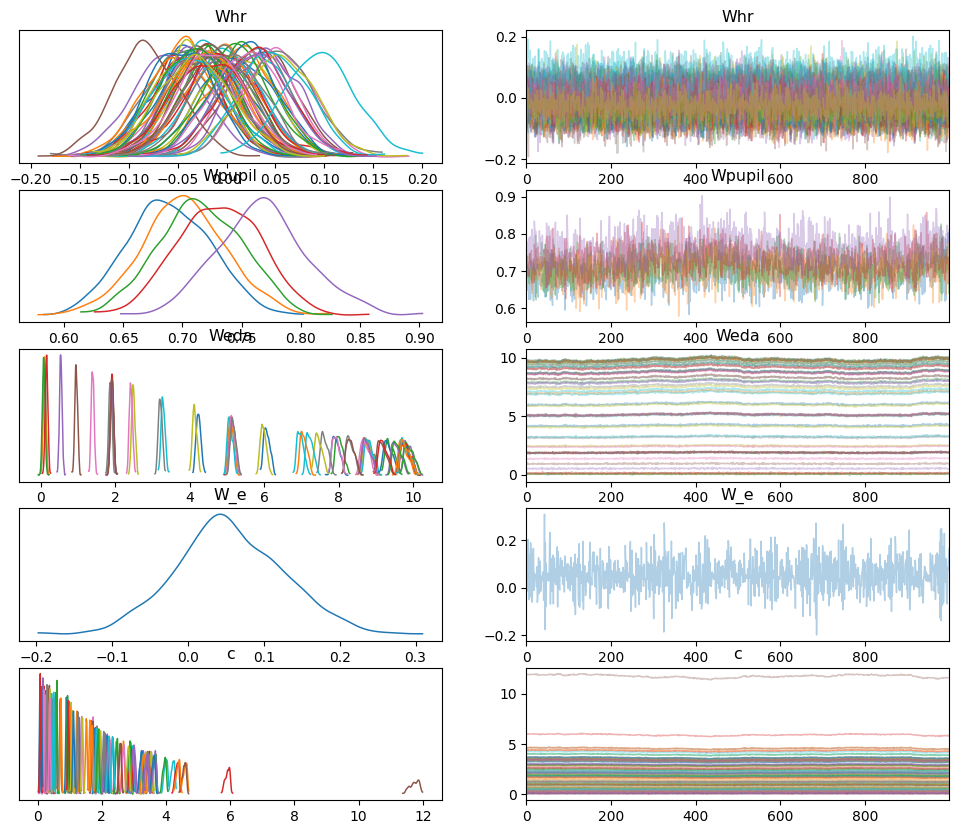

In [26]:
#az.plot_posterior(mean_field.sample(1000), color="LightSeaGreen")
az.plot_trace(trace)
plt.show()

In [27]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"pupil_data": pupil,"hr_data":hr,"eda_data":eda})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)

Sampling: [x_e, x_eda, x_hr, x_pupil]


In [28]:
e_pred = posterior_predictive.posterior_predictive["x_e"]

In [30]:
e_pred_mode = np.squeeze(stats.mode(e_pred[0], keepdims=False)[0])[:,np.newaxis]

In [31]:
e_pred_mode

array([[1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
    

In [32]:
e_labels

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
    

In [33]:
train_accuracy_exp = accuracy_score(e_labels, e_pred_mode)
print('\n\tTrain Accuracy Pain Expectation: ' + str(train_accuracy_exp))
print(' ')


	Train Accuracy Pain Expectation: 0.5178571428571429
 


--------------------------------------------------------------------------------------------

In [34]:
hr_pred_mean = (stats.median_abs_deviation(hr_pred[0]))[0]
hr_pred_mean

NameError: name 'hr_pred' is not defined

In [ ]:
hr[0]

In [ ]:
#hr_pred_mode= pd.Series([0.006,0.01,0.02,0.003])

hr and hr_pred_mode devono avere same shape

In [ ]:
train_accuracy_hr = (np.subtract(hr[0], hr_pred_mean))
print('\n\t avg distance hr: \n' + str(train_accuracy_hr))
#print(' ')

In [ ]:
with sPPCA:
    # update values of predictors:
    pm.set_data({"hr_data": hr})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace, random_seed=123)
    gaze_pred = posterior_predictive.posterior_predictive["x_gaze"]

In [ ]:
gaze_pred

In [ ]:
gaze_pred_mean = np.mean(gaze_pred, axis=0).T.reshape(-1)
gaze_true = pupil.reshape(-1)
reconstructed_r2 = metrics.r2_score(gaze_true, gaze_pred_mean)

print('\n\tReconstructed X R2 score: ' + str(reconstructed_r2))

In [ ]:
import deepemogp.feature_extractor as feature_extractor

In [ ]:
f = feature_extractor.FE('wavelet', window=(8,6), params={'w_mother':'db3','w_maxlev':1})

In [ ]:
x = [3, 7, 1, 1, -2, 5, 4, 6]

In [ ]:
f.apply(x)